### PH464/564: Scientific Computing II
***J.S. Hazboun***
#### Katelyn Ebert
___

# Lecture/Homework 04
### Due: Friday, October 25th at 11:59pm Pacific
---

The purpose of this assignment is to use the Metropolis algorithm to infer model parameters by sampling a _posterior distribution_.  Let's return to our linear regression problem.

Using the synthetic $x-y$ data set from [Hogg, Bovy, and Lang (2010)](https://arxiv.org/abs/1008.4686) (in the `data` directory of this repo), assume a **uniform prior** over slope and y-intercept and use the Metropolis algorithm to draw samples from the posterior density function describing our knowledge of the slope and y-intercept given the observed data.

To do this you will have to extend our 1-D Markov chains from class to 2-D, meaning we have a 2-D parameter space to explore and you will have to decide a method (or methods) to propose moves in those two dimensions.

Show the quality of the fit to the data and the associated uncertainty by plotting the lines corresponding to several samples from your chain on top of the data

Make one or several figures showing your estimate of the 2-D posterior distribution.  Are there correlations between the model parameters?

In [1]:
# All the imports!
import numpy as np 
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

import scipy.stats
from scipy.stats import norm
from scipy.stats import uniform
from astroML import stats as astroMLstats
import math
import seaborn as sns
import corner
import pandas as pd
from scipy.stats import gaussian_kde

In [2]:
## Load in our Intro to Regression Data
data = np.genfromtxt('../data/data_yerr.dat', names=True, comments='#', delimiter='&')
data

array([( 1., 201., 592., 61.), ( 2., 244., 401., 25.),
       ( 3.,  47., 583., 38.), ( 4., 287., 402., 15.),
       ( 5., 203., 495., 21.), ( 6.,  58., 173., 15.),
       ( 7., 210., 479., 27.), ( 8., 202., 504., 14.),
       ( 9., 198., 510., 30.), (10., 158., 416., 16.),
       (11., 165., 393., 14.), (12., 201., 442., 25.),
       (13., 157., 317., 52.), (14., 131., 311., 16.),
       (15., 166., 400., 34.), (16., 160., 337., 31.),
       (17., 186., 423., 42.), (18., 125., 334., 26.),
       (19., 218., 533., 16.), (20., 146., 344., 22.)],
      dtype=[('index', '<f8'), ('x', '<f8'), ('y', '<f8'), ('sigm_y', '<f8')])

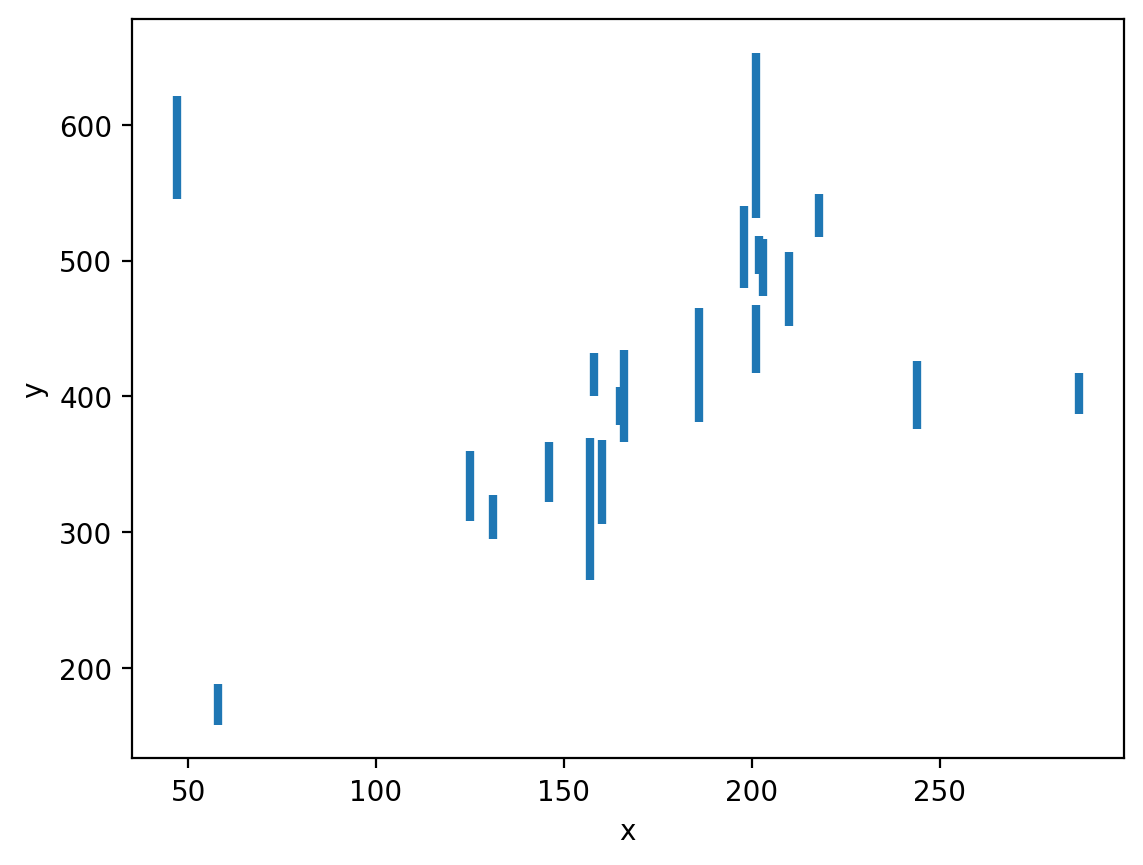

In [3]:
## Let's graph our data so we can choose some reasonable-ish priors
plt.errorbar(data['x'], data['y'], yerr=data['sigm_y'], linewidth=0, elinewidth=3)
plt.xlabel('x')
plt.ylabel('y');

In [4]:
# define our line, define our x-values
x = data['x']
def y(m,b,x):
    return m*x+b
print(x)

[201. 244.  47. 287. 203.  58. 210. 202. 198. 158. 165. 201. 157. 131.
 166. 160. 186. 125. 218. 146.]


In [5]:
def build_model(m, b):
    def model(x):
        return m * x + b
    return model

def lnlikelihood(m, b, x=data['x'], y=data['y'], sigma_y=data['sigm_y']):
    model = build_model(m, b)
    lnlike = -.5*np.sum(np.log(2*np.pi*sigma_y**2)) - np.sum((y - model(x))**2/(2*sigma_y**2)) 
    return lnlike

In [6]:
## Get a sense of which y values and errors we have
print(data['y'])
print(data['sigm_y'])

[592. 401. 583. 402. 495. 173. 479. 504. 510. 416. 393. 442. 317. 311.
 400. 337. 423. 334. 533. 344.]
[61. 25. 38. 15. 21. 15. 27. 14. 30. 16. 14. 25. 52. 16. 34. 31. 42. 26.
 16. 22.]


In [7]:
# Start some walkers for our runs
m0 = 2.
b0 = 100.

m=m0
b=b0
p_current = lnlikelihood(m,b) ## AHHAAA we need to use the log likelihood from Intro to Regression for making jumps!

chain_m = [m]
chain_b = [b]
probs = [p_current]
print(p_current)

-354.1809064685658


In [8]:
### Here was my attempt at making my own likelihood for selecting good jumps - DO NOT USE
### ------------------------------------------------------------------------------------

#print(p_current - data['y'])
#print(np.average(p_current - data['y']))

#mp = scipy.stats.norm.rvs(loc=m,scale=0.5) # define our trial slope
#bp = scipy.stats.norm.rvs(loc=b,scale=0.5) # trial intercept
#p_p = y(mp,bp,x) # trial line?
#print(np.average(np.average((p_p-data['y']))))

#a=[]
#for i in range(len((p_current))):
#    yplus = data['y'][i]+data['sigm_y'][i]      # define the lower error bar for each point
#    yminus = data['y'][i]-data['sigm_y'][i]     # define the upper error bar
#    if yminus < i < yplus:      # test whether our suggested point is within the range of the error bars
#        a.append(0)             # if so, append a distance of "zero" from the error region
#    elif yplus < i:             # test if the point lies above the error bars
#        a.append(i-(yplus))
#    else:
#        a.append(abs(yminus-i))
#print(a)
#print(np.average(a))

In [9]:
niter = 100000 # number of iteration

for i in range(niter):
    mp = scipy.stats.norm.rvs(loc=m,scale=0.01)     #scipy.stats.norm.rvs(loc=m0) # define our trial slope
    bp = scipy.stats.norm.rvs(loc=b,scale=10)     #scipy.stats.norm.rvs(loc=b0) # trial intercept
    p_p = lnlikelihood(mp,bp)
    #print(p_p)
    
    α = np.exp(p_p - p_current) # exponentiate to get the likelihood
    u = np.random.uniform()  
    accepted = α > u
    
    if accepted.all():
        m = mp
        b = bp
        p_current = p_p
    chain_m.append(m)
    chain_b.append(b)
    probs.append(p_current)

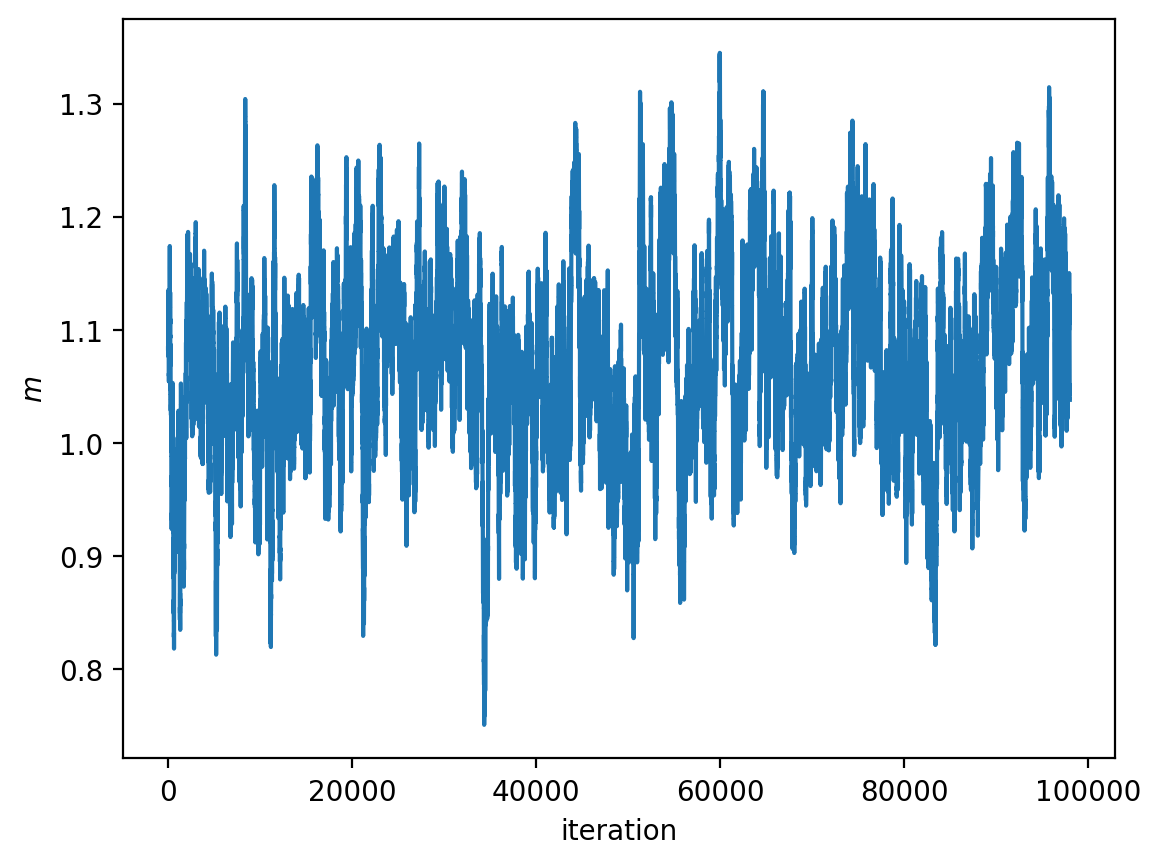

In [10]:
## Checking for fuzzy caterpillar (good exploration of the parameter space)
burnin_length = 2000    # allow the walker to settle in to a groove

plt.plot(chain_m[burnin_length:])
plt.xlabel('iteration')
plt.ylabel('$m$');

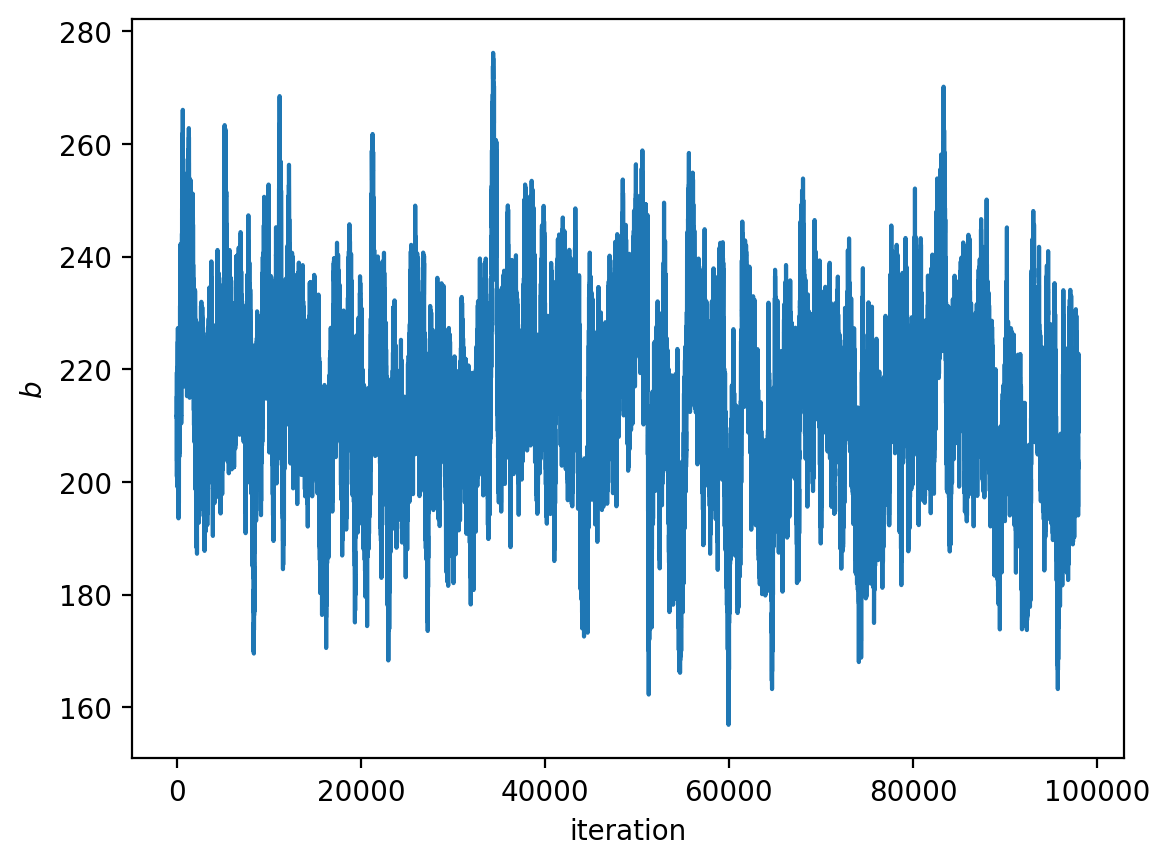

In [11]:
# Same thing for our intercept
burnin_length = 2000

plt.plot(chain_b[burnin_length:])
plt.xlabel('iteration')
plt.ylabel('$b$');

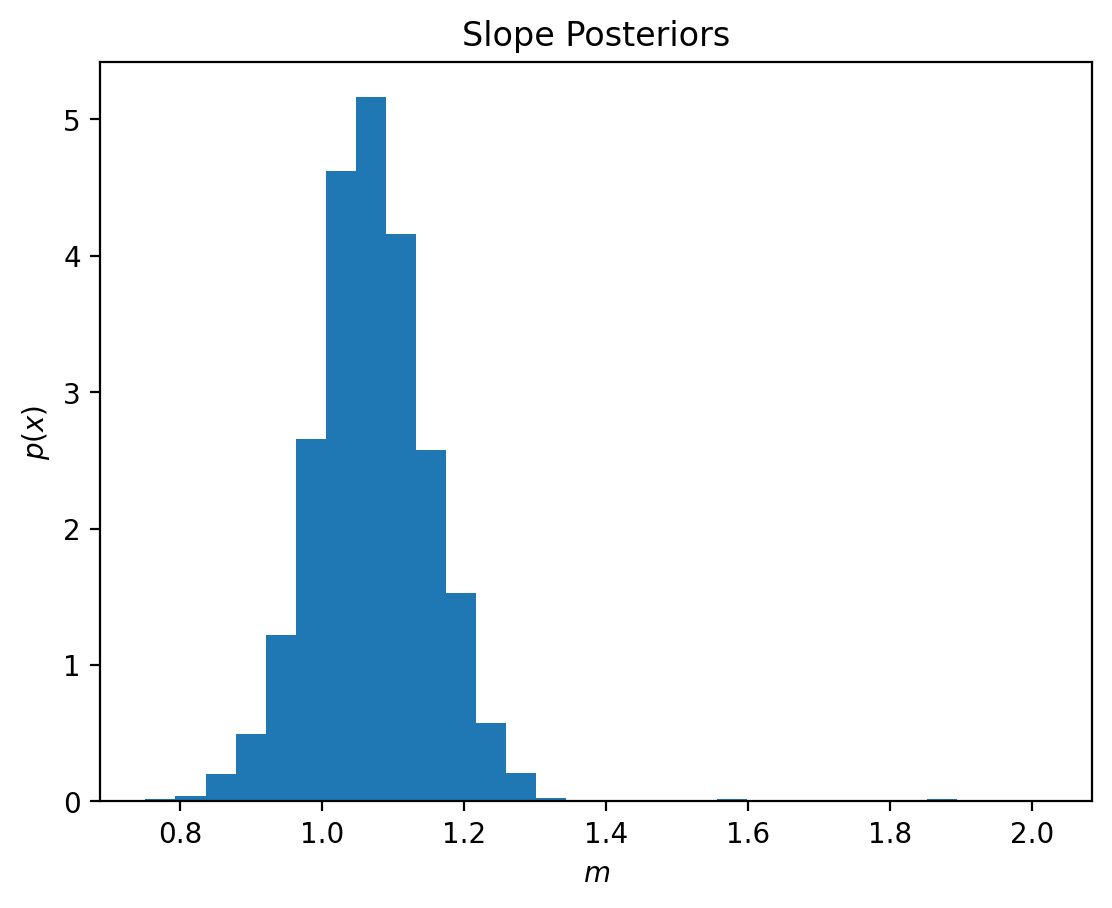

In [12]:
# Posteriors for our Slope
plt.hist(chain_m, density=True, bins=30, label='chain') # let's get a sense of the slope posteriors by plotting
plt.xlabel('$m$')
plt.ylabel('$p(x)$')
plt.title('Slope Posteriors');

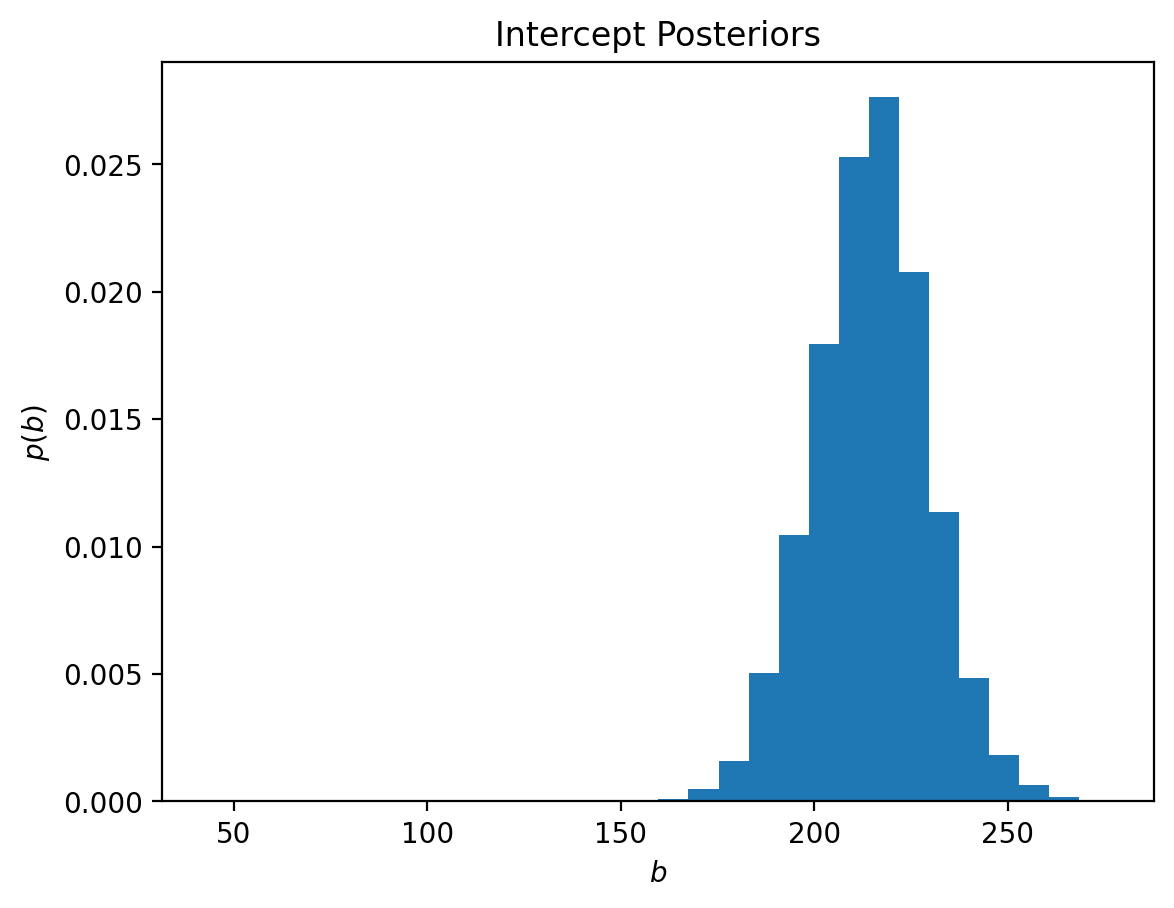

In [13]:
plt.hist(chain_b, density=True, bins=30, label='chain')
plt.xlabel('$b$')
plt.ylabel('$p(b)$')
plt.title('Intercept Posteriors');

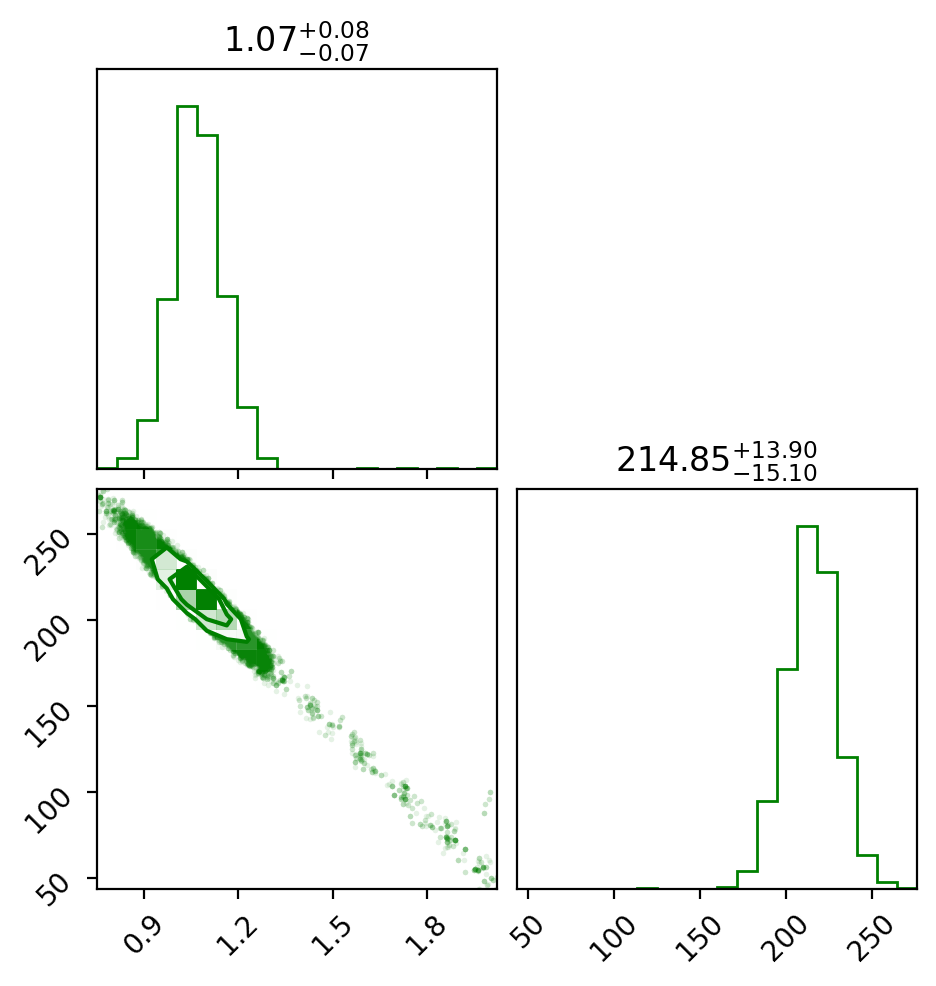

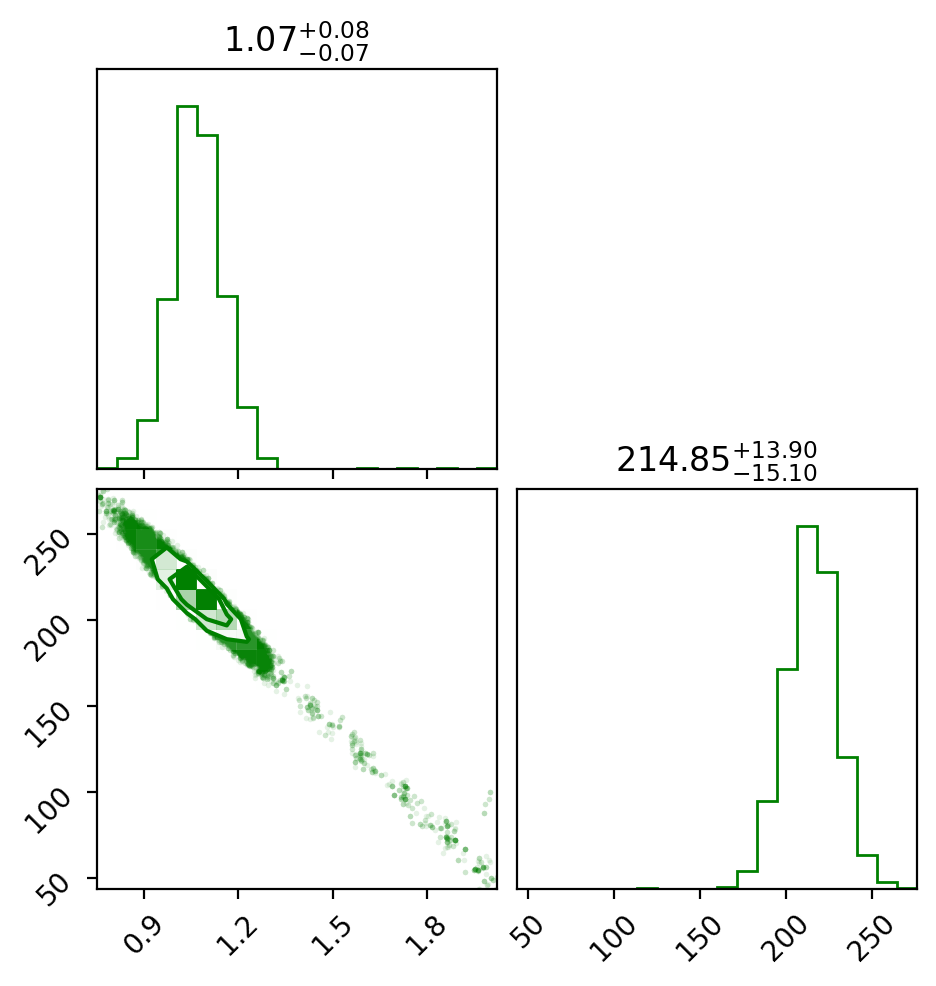

In [14]:
test = np.column_stack([chain_m,chain_b])
corner.corner(test,color='green',show_titles=True)

Above is our corner plot which shows the covariance of slope and intercept. It makes sense that the two are highly coorelated: if the intercept shifts down the y-axis, the line needs a steeper slope to hit the points, and vice versa. Hence, possible values that aren't immediately rejected lie on a line in our covariance plot. To see our quality of fit, let's plot our best-fit line, plus the lines from one standard deviation away

In [15]:
xvals = np.linspace(0,300,1000)
def bestfit(b,m):
    return m*xvals+b

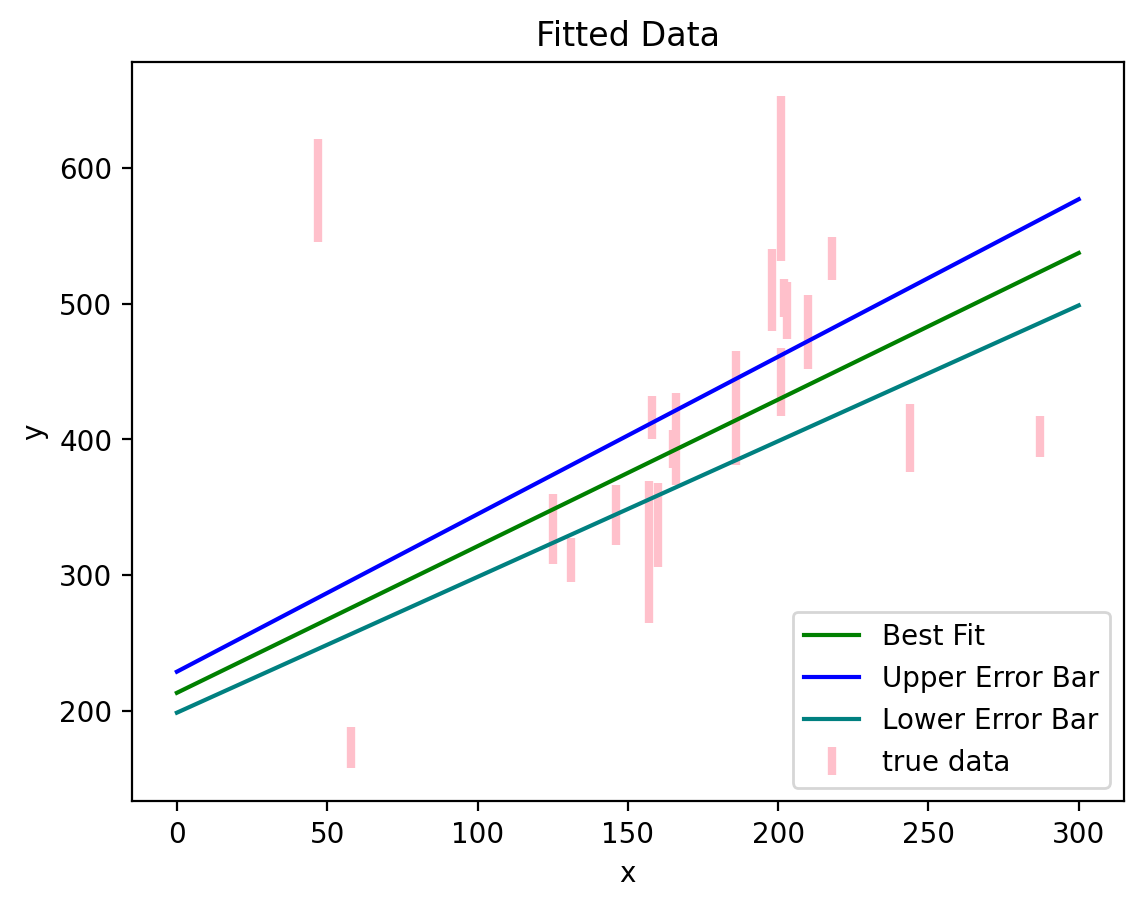

In [16]:

plt.errorbar(data['x'], data['y'], yerr=data['sigm_y'], linewidth=0, elinewidth=3, label='true data', color='pink')
plt.plot(xvals,bestfit(213.26,1.08),color='g',label='Best Fit')
plt.plot(xvals,bestfit(228.83,1.16),color='blue',label='Upper Error Bar')
plt.plot(xvals,bestfit(198.64,1.),color='teal',label='Lower Error Bar')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Fitted Data')
plt.legend()
plt.show();

Looks beautiful!

## 564 Students

Use the same technique for constraining a linear model connecting the color and brightness of nearby main sequence stars observed by Gaia (parallax > 40 mas).  To do this you will need to:

1. Select only the stars from the data set with parallax > 40 mas.
1. (crudely) remove the white dwarfs (constructing a dividing line by eye is fine for this).
1. Define your likelihood.  This will be similar to the last linear regression likelihood, except that we don't have uncertainties on measurements of the brightness, Mg.  Even if we did, the scatter about the linear relationship is due to physics not measurement uncertainty, so we'll need to infer it from the data.
1. Define priors.  Uniform priors on slope and y-intercept are fine, but you'll need to impose a prior on the scatter in $M_G$ about the line, $\sigma_{M_G}$, that ensures it stays positive and doesn't run away.  I suggest a normal distribution with $\sigma \sim 5$ for $\sigma_{M_G} > 0$.
1. Perform your first 3-D MCMC.

Show the quality of the fit to the data and the associated uncertainty by plotting the lines corresponding to several samples from your chain on top of the data.

Are there correlations between the constraints on the model parameters?

What did we infer regarding the scatter about the line, $\sigma_{M_G}$, and how does it compare to your by-eye assessment of the width of the scatter along the main sequence?

In [17]:
df = pd.read_csv('../data/gaiadr3_solar_neighborhood.csv')
df

,mg,bp_rp,parallax
0,10.390250,2.731872,10.000008
1,8.608481,2.025819,10.000029
2,4.267759,0.880858,10.000032
3,10.506658,2.649735,10.000066
4,12.077941,2.940875,10.000111
...,...,...,...
227624,11.758283,2.834036,336.026602
227625,9.521769,2.215609,392.752945
227626,14.129570,4.184836,415.179416
227627,11.883816,2.833697,546.975940


### 1. Selecting parallax > 40 stars

In [18]:
nearby_sel = df.parallax > 40.
nearby_df = df[nearby_sel]

Text(0, 0.5, '$M_G$')

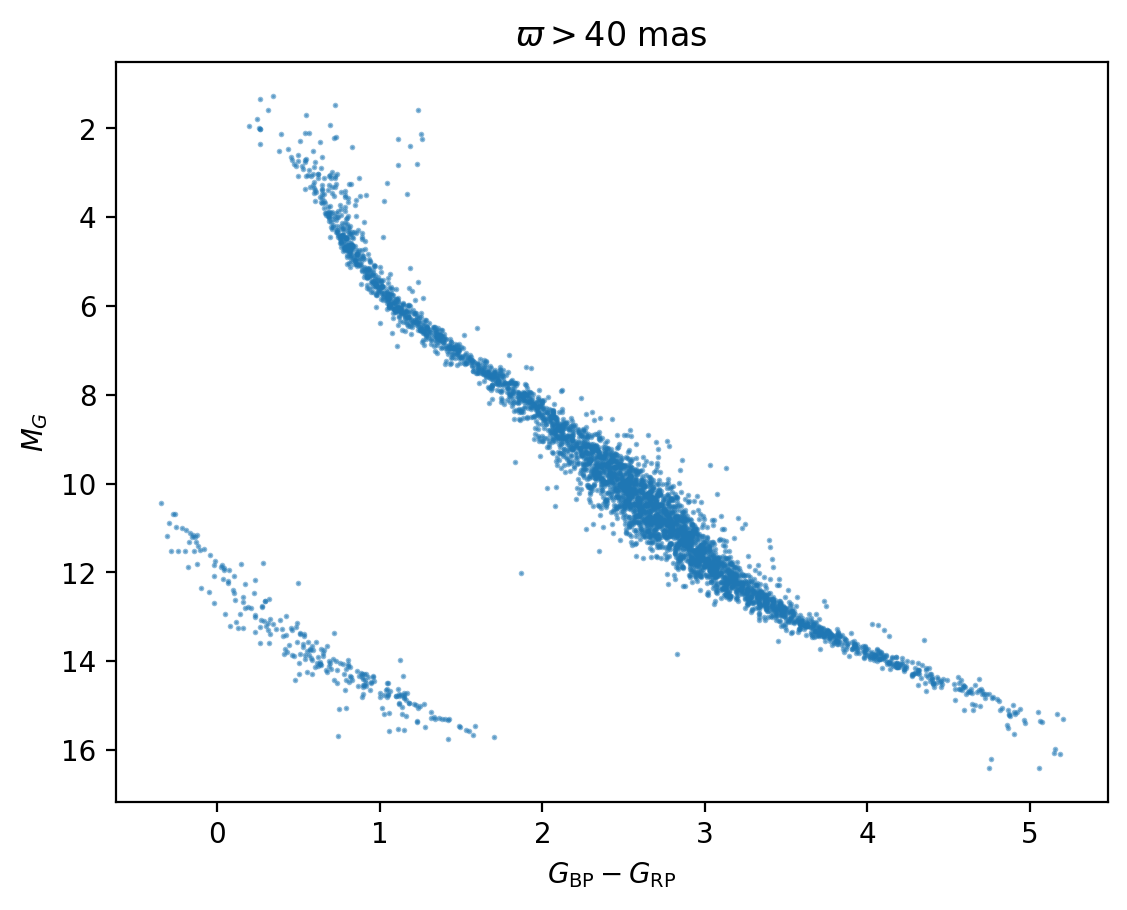

In [19]:
plt.scatter(nearby_df.bp_rp, nearby_df.mg, s=1, alpha=0.5)
plt.gca().invert_yaxis()
plt.title(r'$\varpi > 40$ mas')
plt.xlabel(r"$G_\mathrm{BP} - G_\mathrm{RP}$")
plt.ylabel(r"$M_G$")

From this plot, it looks like a rough estimate of 0-2 $G_{BP} - G_{RP} $ and 10-16 $M_G$ is our white dwarf region that we'll want to brute-force remove

### 2. Remove White Dwarfs (crudely) 

In [20]:
dwarf_sel = df.mg > 10 # white dwarfs are greater than 10 on y-axis
white_sel = df.bp_rp < 2 # and less than two on x-axis
dwarfless_df = df[~(white_sel & dwarf_sel) & nearby_sel] # remove these simultaneously, while continuing >40 parallax condition

Text(0, 0.5, '$M_G$')

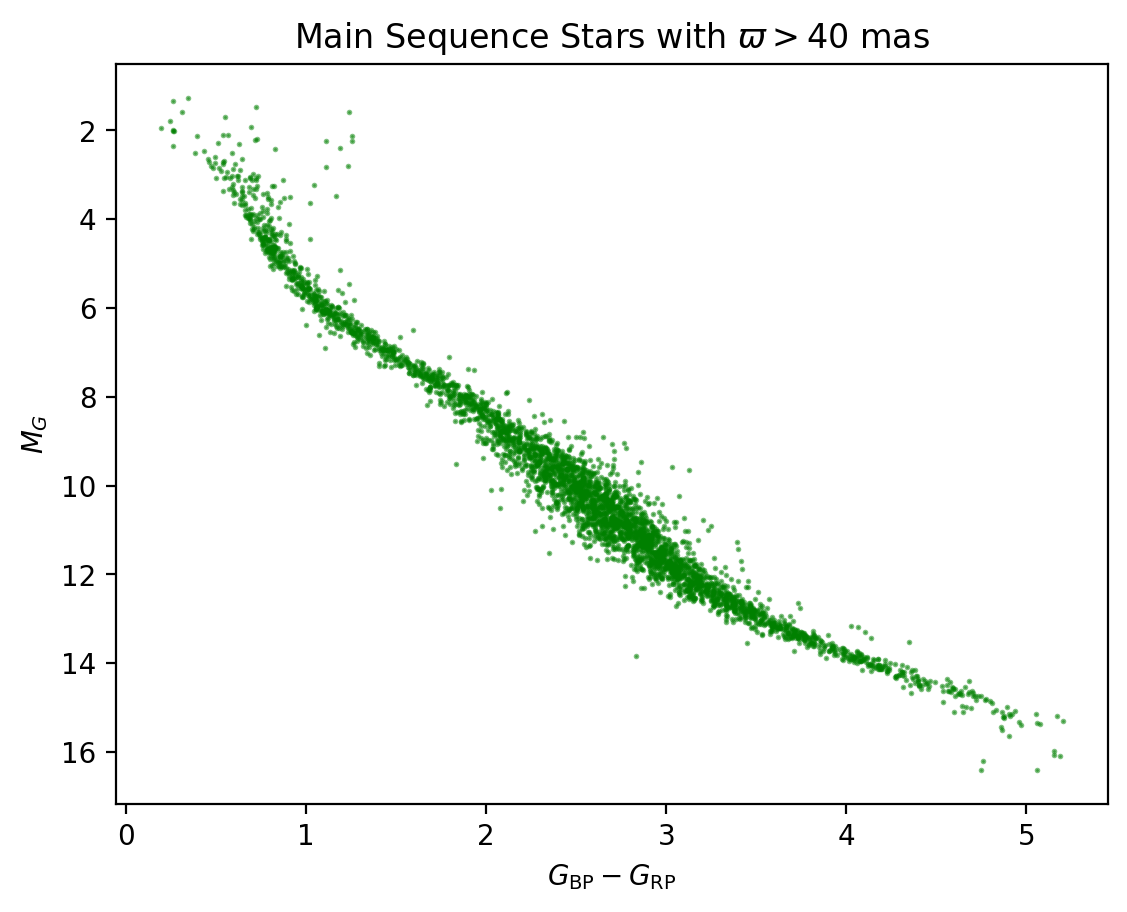

In [21]:
# Plot again to make sure the filtering works
plt.scatter(dwarfless_df.bp_rp, dwarfless_df.mg, s=1, alpha=0.5, color='g')
plt.gca().invert_yaxis()
plt.title(r'Main Sequence Stars with $\varpi > 40$ mas')
plt.xlabel(r"$G_\mathrm{BP} - G_\mathrm{RP}$")
plt.ylabel(r"$M_G$")

Ah, and now we have our main sequence stars isolated. Perfect!

### 3. Construct Likelihood

I guess we'll assume the main sequence stars fall on a line (it's pretty close to that, right?) so we'll use the same likelihood definition as before, except remove the scaling by uncertainty.

In [22]:
def build_model(m, b):
    def model(x):
        return m * x + b
    return model

def lnlikelihood(m, b, sigma, x=dwarfless_df.bp_rp, y=dwarfless_df.mg): # subbing in our new x and y true values
    N = x.size
    model = build_model(m, b)
    lnlike = -.5*N*(np.log(2*np.pi*sigma**2)) - (1/(2*sigma**2))*np.sum((y - model(x))**2) 
    if sigma < 0:
        lnlike = -np.inf
    return lnlike

### 4. Define our Priors

In [23]:
# Start some walkers for our runs
m0 = 4.
b0 = 2.
sigma0 = 5 # begin with 5 as our starting scale for scatter

m=m0
b=b0
sigma=sigma0
p_current = lnlikelihood(m,b,sigma) 

chain_m = [m]
chain_b = [b]
chain_sigma = [sigma]
probs = [p_current]
print(p_current)

-10080.451644503879


### 5. Perform 3D MCMC

In [24]:
niter = 500000 # number of iteration

for i in range(niter):
    # Define each of our new trial values
    mp = scipy.stats.norm.rvs(loc=m,scale=1)      # define our trial slope
    bp = scipy.stats.norm.rvs(loc=b,scale=1)      # trial intercept
    sigmap = scipy.stats.norm.rvs(loc=sigma,scale=1)  # trial scatter
    
    # Define our likelihoods; each likelihood varies independently - our variables are "uncoupled"
    mjump = lnlikelihood(mp,b,sigma)
    bjump = lnlikelihood(m,bp,sigma)
    sigmajump = lnlikelihood(m,b,sigmap)

    # Define our acception conditions
    u = np.random.uniform()
    α = np.exp(mjump - p_current) # exponentiate to get the likelihood with m alone being changed
    m_accepted = α > u  # define this accepted condition
    α = np.exp(bjump - p_current) # it's fine that we're writing over cause we already used previous alpha for defining jump condition
    b_accepted = α > u
    α = np.exp(sigmajump - p_current)
    sigma_accepted = α > u

    if m_accepted.all():
        m = mp
    
    if b_accepted.all():
        b = bp

    if sigma_accepted.all():
        sigma = sigmap

    p_current = lnlikelihood(m,b,sigma)     # reset p_current with any updates to m,b, or width
    chain_m.append(m)   # append whichever m was kept
    chain_b.append(b)     
    chain_sigma.append(sigma)
    probs.append(p_current)

/tmp/ipykernel_343109/907546763.py:20: RuntimeWarning: overflow encountered in exp
  α = np.exp(sigmajump - p_current)


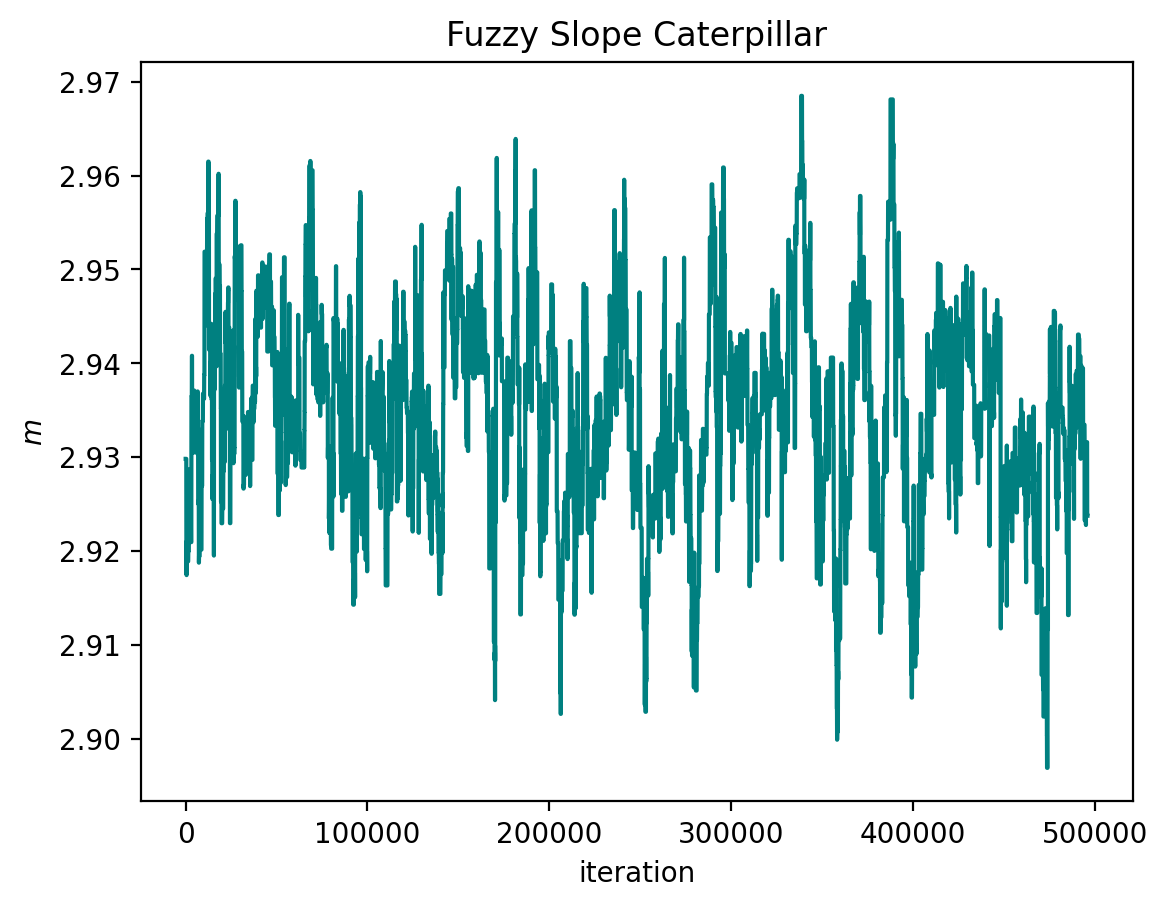

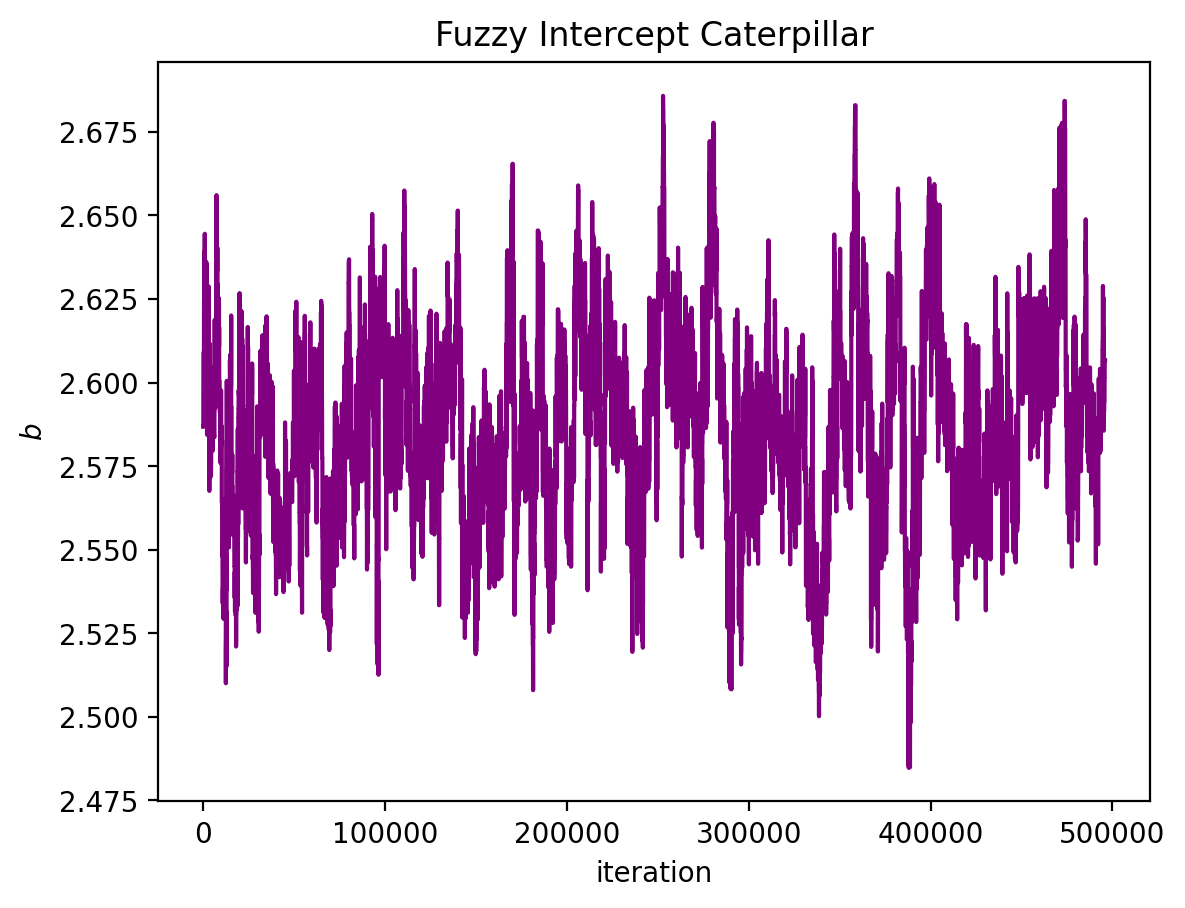

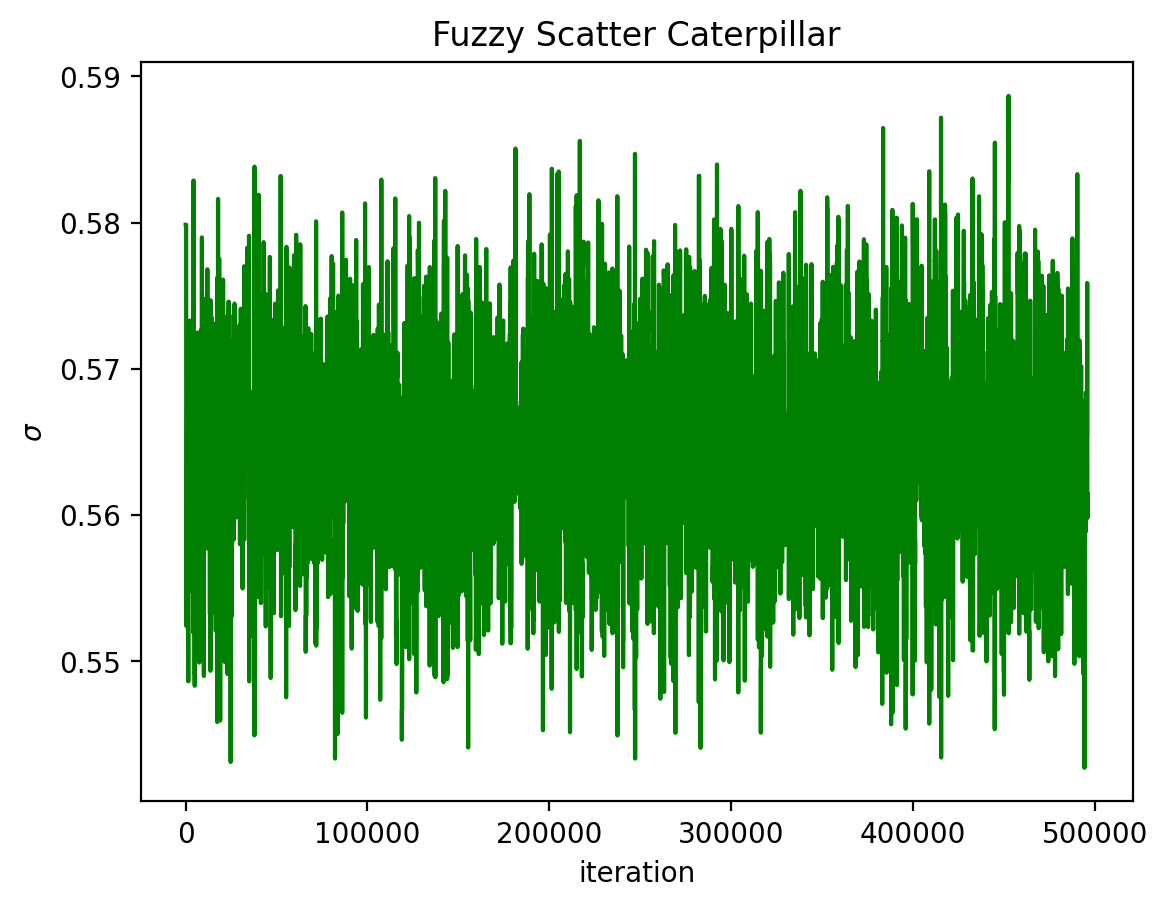

In [25]:
## Checking for fuzzy caterpillar (good exploration of the parameter space)
burnin_length = 4000    # allow the walker to settle in to a groove

plt.plot(chain_m[burnin_length:], color='teal')
plt.xlabel('iteration')
plt.ylabel('$m$')
plt.title('Fuzzy Slope Caterpillar')
plt.show()

plt.plot(chain_b[burnin_length:], color='purple')
plt.xlabel('iteration')
plt.ylabel('$b$')
plt.title('Fuzzy Intercept Caterpillar')
plt.show()

plt.plot(chain_sigma[burnin_length:], color = 'green')
plt.xlabel('iteration')
plt.ylabel('$\sigma$')
plt.title('Fuzzy Scatter Caterpillar')
plt.show()

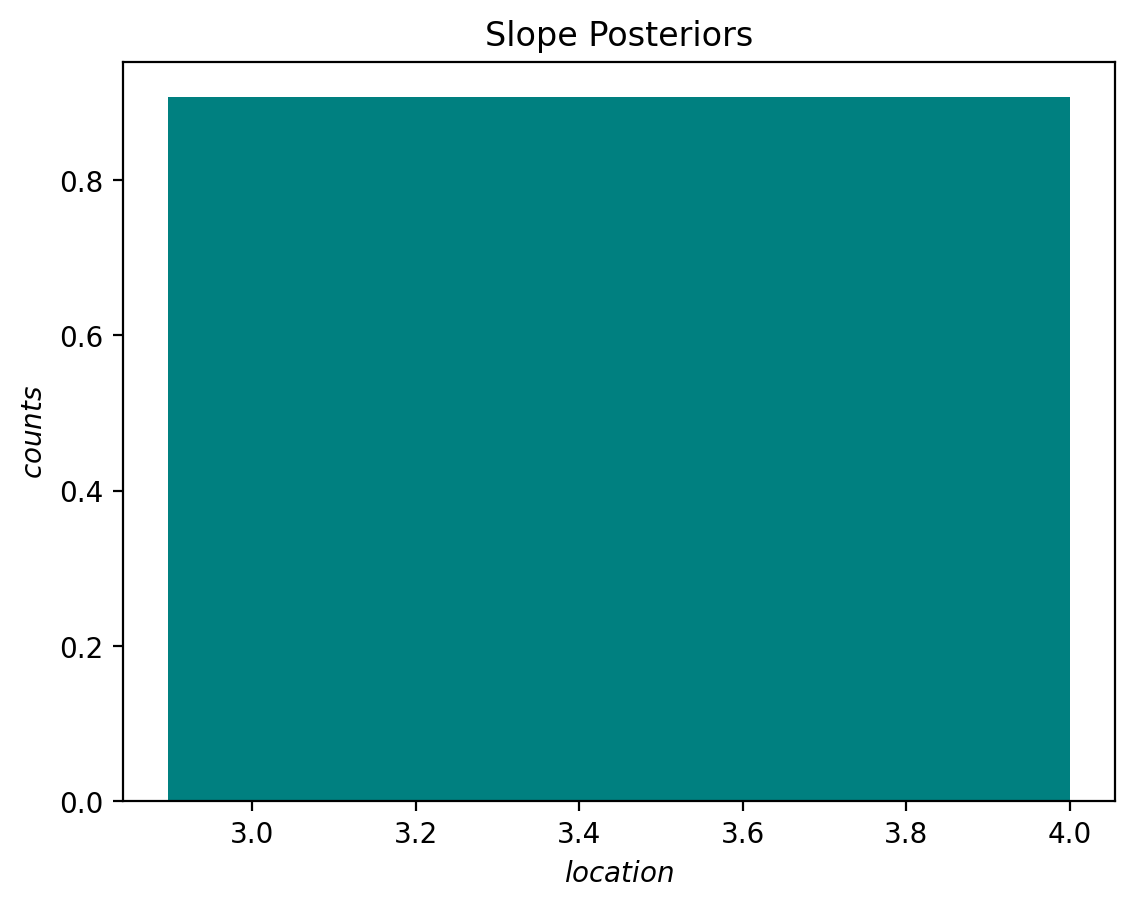

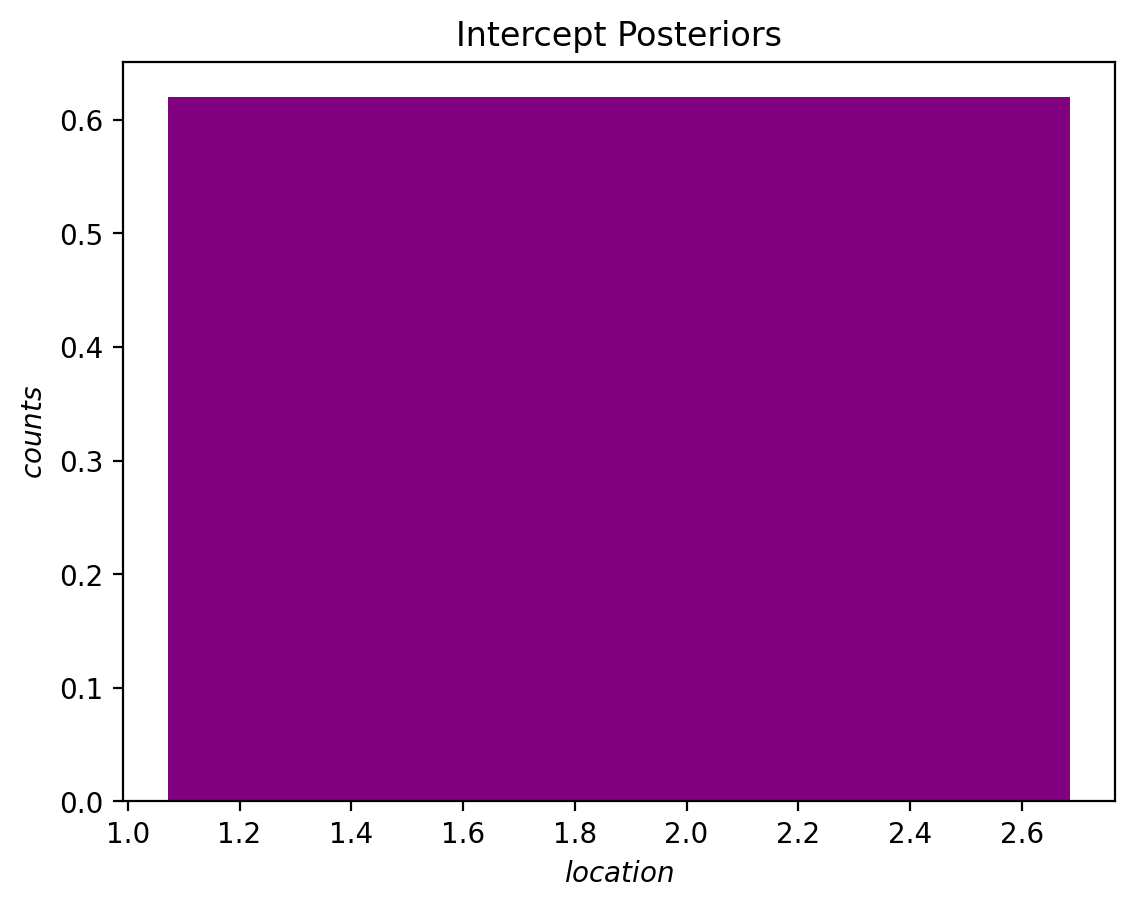

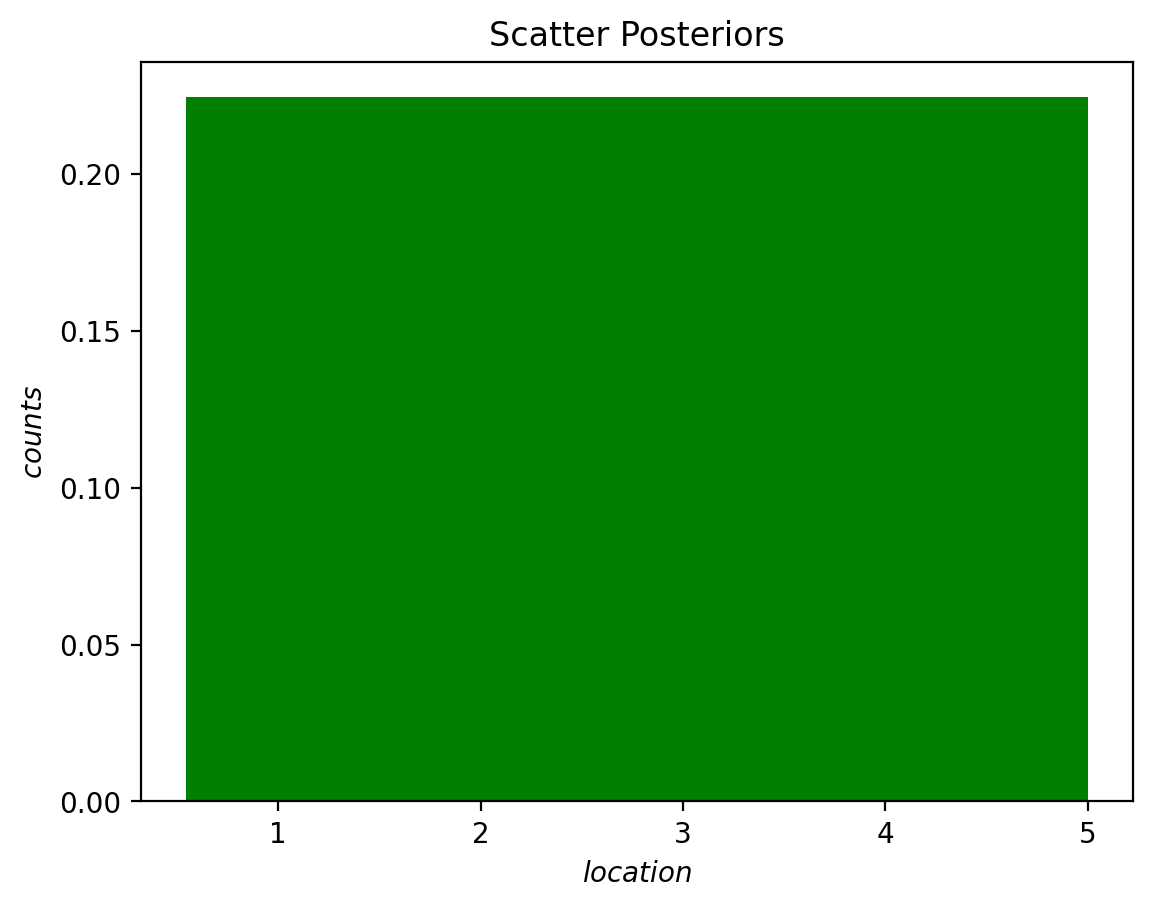

In [26]:
## Posterior Time!

plt.hist(chain_m, density=True, bins=1, label='slope', color = 'teal')
plt.xlabel('$location$')
plt.ylabel('$counts$')
plt.title('Slope Posteriors')
plt.show()

plt.hist(chain_b, density=True, bins=1, label='intercept', color = 'purple')
plt.xlabel('$location$')
plt.ylabel('$counts$')
plt.title('Intercept Posteriors')
plt.show()

plt.hist(chain_sigma, density=True, bins=1, label='intercept', color = 'green')
plt.xlabel('$location$')
plt.ylabel('$counts$')
plt.title('Scatter Posteriors')
plt.show()

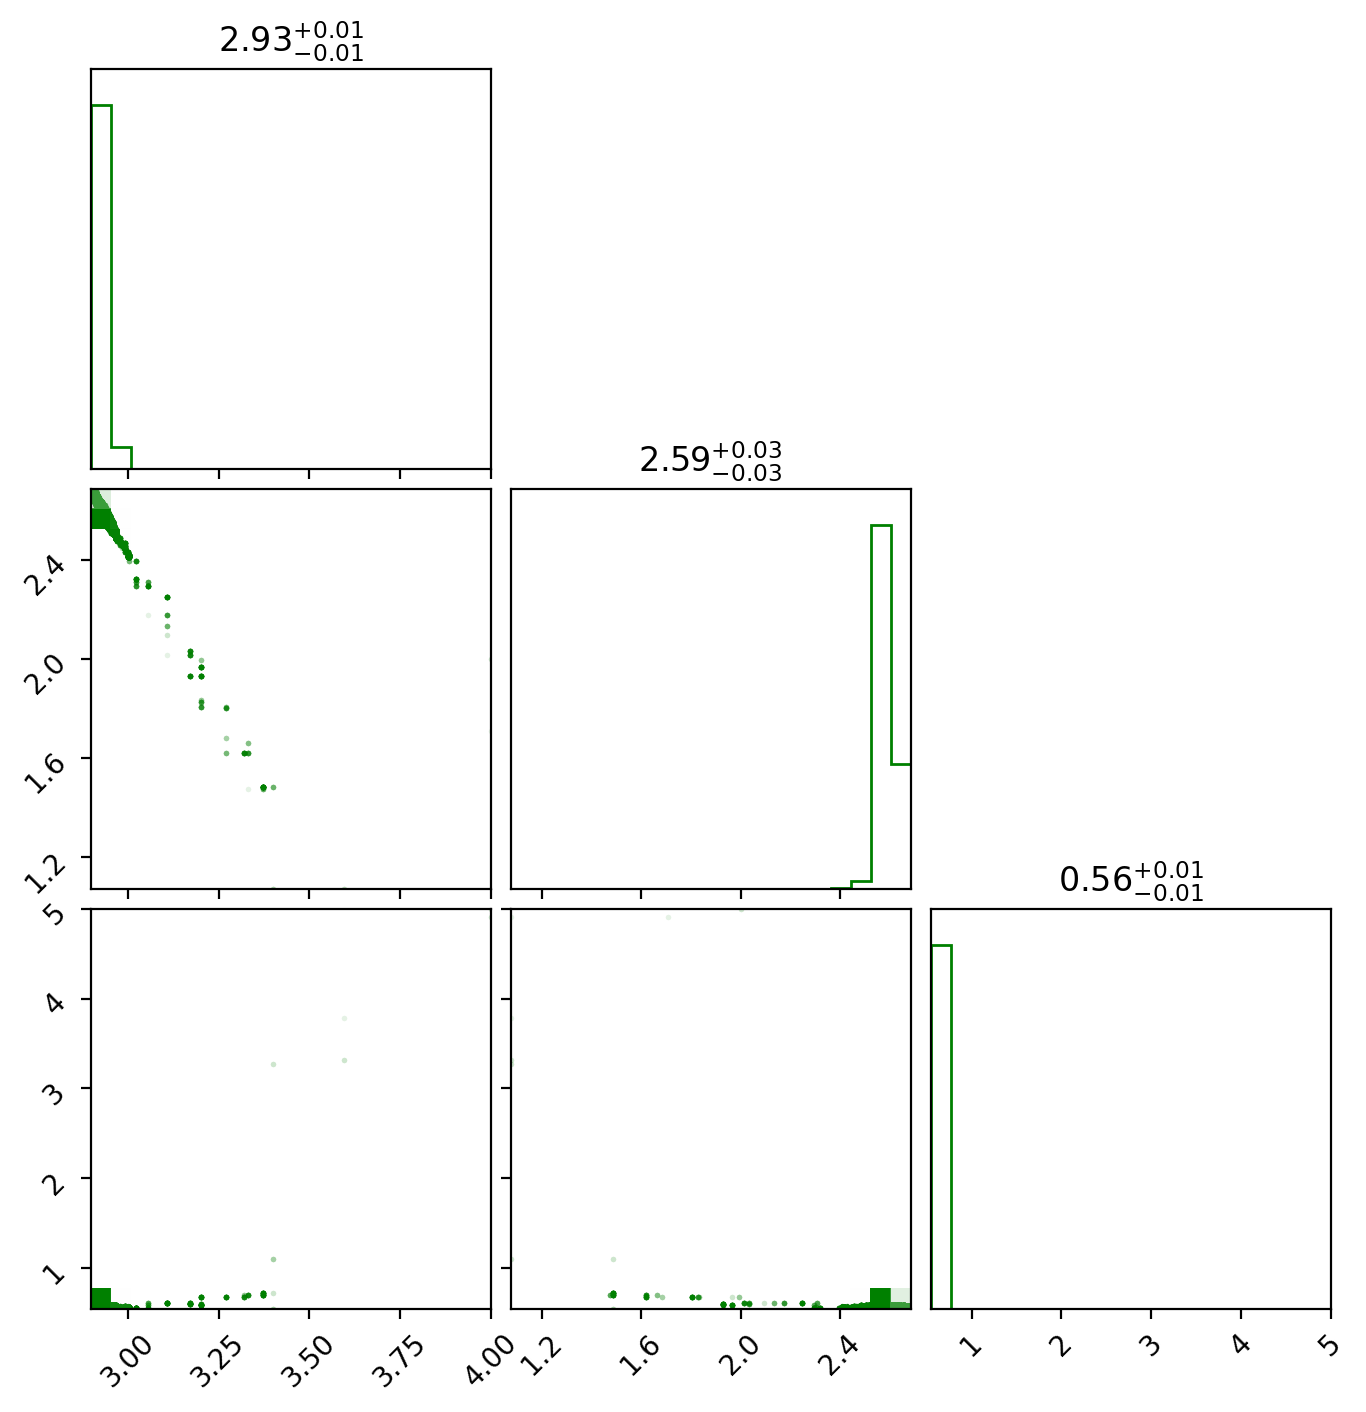

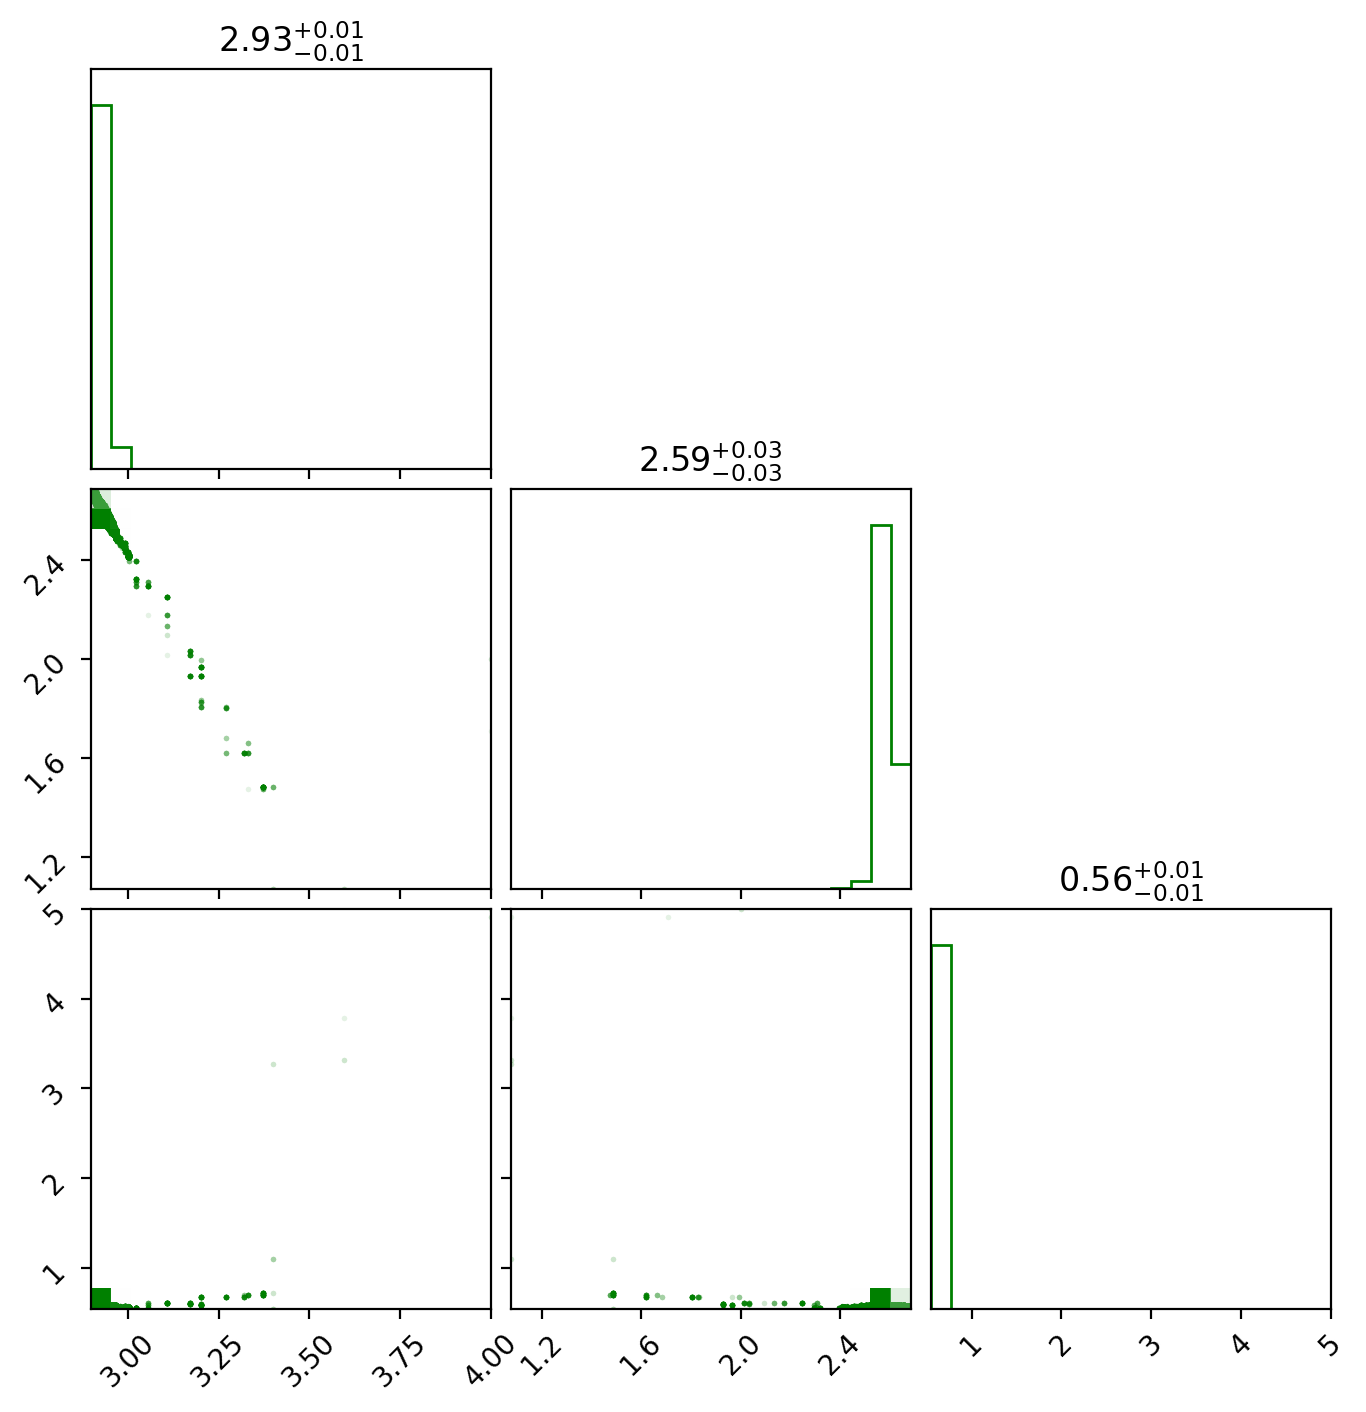

In [27]:
test = np.column_stack([chain_m,chain_b,chain_sigma])
corner.corner(test,color='green',show_titles=True)

Okay, so something went... wrong when I updated my likelihood function. I'm trying to figure out what, but my runs take 3 - 15 mins. I *had* gotten my slope and intercept to converge previously, which yielded the following corner plot:
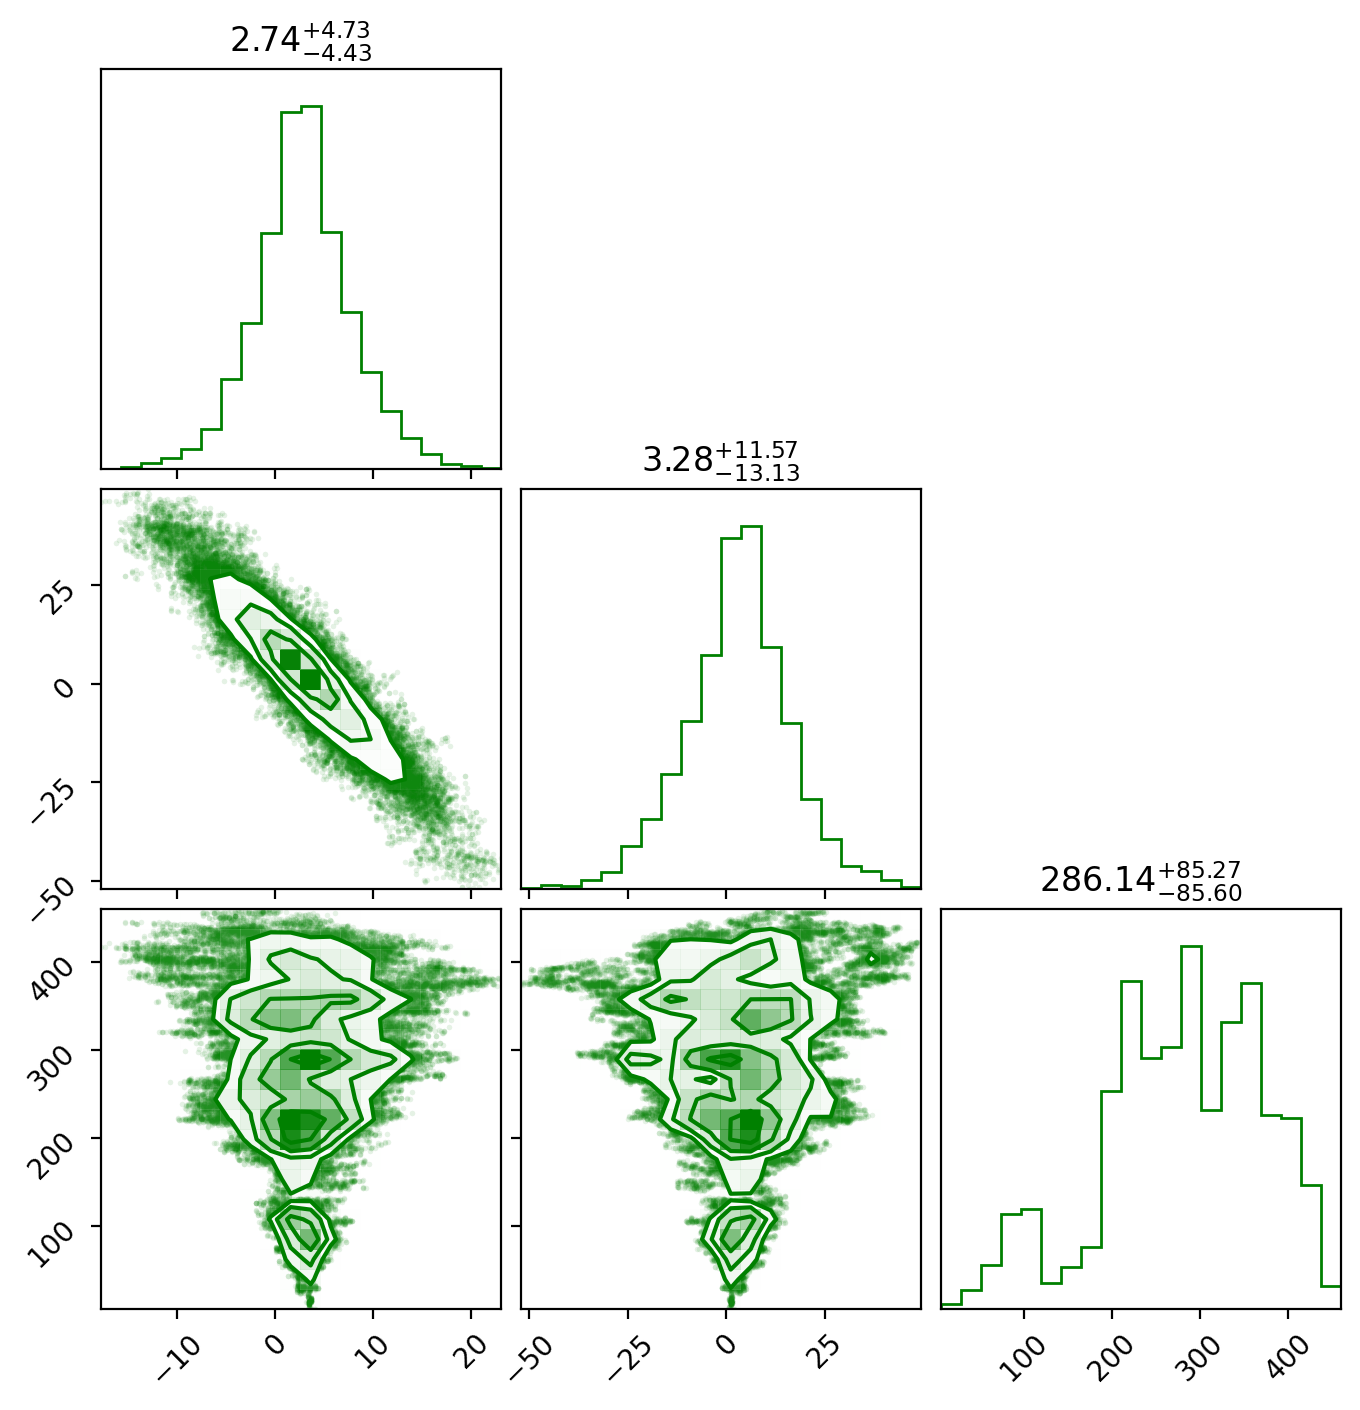

With this corner, we get an average slope of 2.74 and an intercept of 3.28. Our sigmas did not converge, because I had forgotten to include the cutoff for negative sigmas (setting their likelihood to -infinity) and the division by the number of data points. Hence, we ended up with a huge scatter

Text(0, 0.5, '$M_G$')

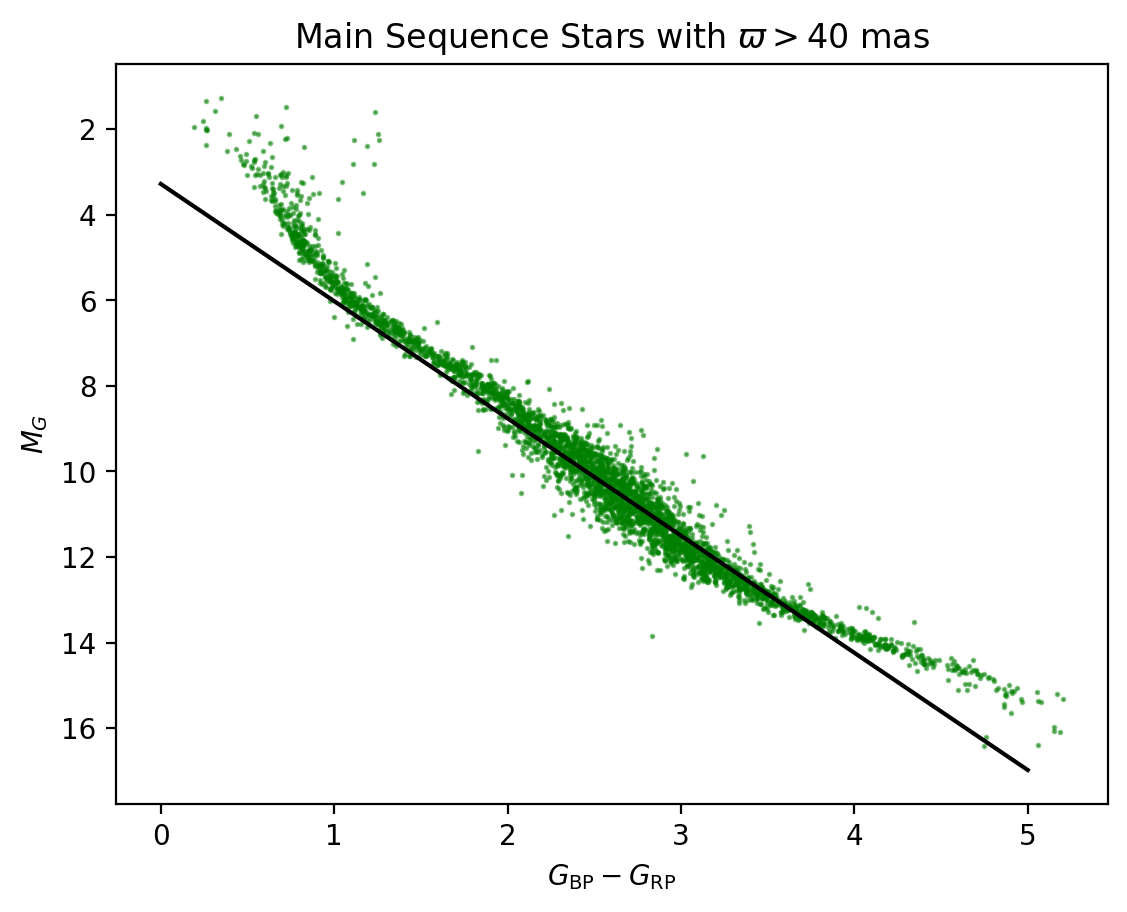

In [28]:
# Plot data and trendlines
plt.scatter(dwarfless_df.bp_rp, dwarfless_df.mg, s=1, alpha=0.5, color='g')
x=np.linspace(0,5,100)
b=3.28
m=2.74
def y(m,b):
    return m*x+b
plt.plot(x,y(m,b),color='black')
plt.gca().invert_yaxis()
plt.title(r'Main Sequence Stars with $\varpi > 40$ mas')
plt.xlabel(r"$G_\mathrm{BP} - G_\mathrm{RP}$")
plt.ylabel(r"$M_G$")

This looks like a really good match to our data!